In [1]:
!pip install roboflow pycocotools tqdm matplotlib torchvision
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="5pEbFhHuFiYqILdQqK0r")
project = rf.workspace("questao2").project("spine_cone-byyoj")
version = project.version(6)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to spine_cone-6 in coco-segmentation:: 100%|██████████| 94/94 [00:00<00:00, 4494.53it/s]


In [9]:
import os
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.transforms import functional as F
from torchvision.utils import draw_segmentation_masks
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import json
from pycocotools.coco import COCO
from torchvision import transforms
from sklearn.metrics import f1_score
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import cv2

In [5]:
# Caminho base do dataset no Google Colab
dataset_path = '/content/spine_cone-6'

# Nomes das subpastas
folders = ['train', 'valid', 'test']

# Extensões válidas para imagens
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

# Função para contar imagens
def count_images(folder_path):
    return sum(
        1 for file in os.listdir(folder_path)
        if os.path.splitext(file)[1].lower() in image_extensions
    )

# Contar e exibir o número de imagens em cada pasta
total = 0
for folder in folders:
    path = os.path.join(dataset_path, folder)
    count = count_images(path)
    total += count
    print(f'{folder}: {count} imagens')

print(f'Total: {total} imagens')


train: 69 imagens
valid: 8 imagens
test: 9 imagens
Total: 86 imagens


In [10]:
class CocoSegmentationDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms
        # Crear un objeto CLAHE (los argumentos son opcionales)
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        # Converter imagem PIL para array numpy para o OpenCV
        img_np = np.array(img)

        # Se a imagem for colorida, converter para LAB e aplicar CLAHE no canal L
        if len(img_np.shape) == 3:
            img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(img_lab)
            l_clahe = self.clahe.apply(l)
            img_lab_clahe = cv2.merge((l_clahe, a, b))
            img_np = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2RGB)
        else: # Se for escala de cinza
            img_np = self.clahe.apply(img_np)

        # Converter array numpy de volta para imagem PIL
        img = Image.fromarray(img_np)

        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx])
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img.size[1], img.size[0]), dtype=np.uint8)
        for ann in anns:
            if not ann["segmentation"]:
                continue

            try:
                cat_id = ann['category_id']
                rle = self.coco.annToMask(ann)
                mask[rle > 0] = cat_id
            except Exception as e:
                print(f"Ignorando anotação inválida (ID {ann['id']}): {e}")
                continue

        mask = Image.fromarray(mask)

        if self._transforms:
            img, mask = self._transforms(img, mask)

        img = transforms.functional.to_tensor(img)
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [11]:
class CustomTransform():
    def __call__(self, img, mask):
        img = transforms.functional.resize(img, (640, 640))
        mask = transforms.functional.resize(mask, (640, 640), interpolation=transforms.InterpolationMode.NEAREST)
        return img, mask

def get_loader(folder, batch_size=8):
    img_dir = os.path.join(folder)
    ann_path = os.path.join(folder, "_annotations.coco.json")
    dataset = CocoSegmentationDataset(img_dir, ann_path, transforms=CustomTransform())
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Cria os DataLoaders
train_loader = get_loader(dataset.location + "/train")
val_loader = get_loader(dataset.location + "/valid")
test_loader = get_loader(dataset.location + "/test")

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [12]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(loader, desc="Treinando"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, masks.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, masks in tqdm(loader):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds.flatten())
            y_true.extend(masks.cpu().numpy().flatten())
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

In [13]:
# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo DeepLabV3+ com encoder ResNet-50
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 50
for epoch in range(n_epochs):
    print(f"\nÉpoca {epoch+1}/{n_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_f1 = evaluate(model, val_loader)
    print(f"Loss de treino: {train_loss:.4f} | F1 Val: {val_f1:.4f}")


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Época 1/50


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Loss de treino: 0.5314 | F1 Val: 0.7980

Época 2/50


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Loss de treino: 0.4205 | F1 Val: 0.6855

Época 3/50


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Loss de treino: 0.3144 | F1 Val: 0.7563

Época 4/50


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Loss de treino: 0.2370 | F1 Val: 0.7651

Época 5/50


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Loss de treino: 0.1858 | F1 Val: 0.8565

Época 6/50


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Loss de treino: 0.1532 | F1 Val: 0.8364

Época 7/50


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Loss de treino: 0.1302 | F1 Val: 0.8313

Época 8/50


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Loss de treino: 0.1143 | F1 Val: 0.8930

Época 9/50


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Loss de treino: 0.1015 | F1 Val: 0.9132

Época 10/50


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Loss de treino: 0.0905 | F1 Val: 0.9159

Época 11/50


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Loss de treino: 0.0839 | F1 Val: 0.9161

Época 12/50


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Loss de treino: 0.0803 | F1 Val: 0.9062

Época 13/50


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Loss de treino: 0.0722 | F1 Val: 0.9164

Época 14/50


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Loss de treino: 0.0671 | F1 Val: 0.9177

Época 15/50


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Loss de treino: 0.0642 | F1 Val: 0.9198

Época 16/50


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Loss de treino: 0.0598 | F1 Val: 0.9229

Época 17/50


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Loss de treino: 0.0568 | F1 Val: 0.9229

Época 18/50


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Loss de treino: 0.0552 | F1 Val: 0.9233

Época 19/50


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Loss de treino: 0.0523 | F1 Val: 0.9194

Época 20/50


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Loss de treino: 0.0509 | F1 Val: 0.9230

Época 21/50


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Loss de treino: 0.0484 | F1 Val: 0.9250

Época 22/50


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Loss de treino: 0.0470 | F1 Val: 0.9291

Época 23/50


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Loss de treino: 0.0445 | F1 Val: 0.9291

Época 24/50


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Loss de treino: 0.0434 | F1 Val: 0.9291

Época 25/50


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Loss de treino: 0.0420 | F1 Val: 0.9309

Época 26/50


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Loss de treino: 0.0411 | F1 Val: 0.9327

Época 27/50


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Loss de treino: 0.0394 | F1 Val: 0.9304

Época 28/50


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Loss de treino: 0.0383 | F1 Val: 0.9308

Época 29/50


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Loss de treino: 0.0373 | F1 Val: 0.9316

Época 30/50


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Loss de treino: 0.0367 | F1 Val: 0.9310

Época 31/50


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Loss de treino: 0.0359 | F1 Val: 0.9328

Época 32/50


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Loss de treino: 0.0352 | F1 Val: 0.9338

Época 33/50


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Loss de treino: 0.0342 | F1 Val: 0.9340

Época 34/50


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Loss de treino: 0.0336 | F1 Val: 0.9328

Época 35/50


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Loss de treino: 0.0328 | F1 Val: 0.9341

Época 36/50


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Loss de treino: 0.0321 | F1 Val: 0.9368

Época 37/50


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Loss de treino: 0.0320 | F1 Val: 0.9376

Época 38/50


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Loss de treino: 0.0313 | F1 Val: 0.9297

Época 39/50


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Loss de treino: 0.0310 | F1 Val: 0.9386

Época 40/50


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Loss de treino: 0.0298 | F1 Val: 0.9369

Época 41/50


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Loss de treino: 0.0294 | F1 Val: 0.9333

Época 42/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Loss de treino: 0.0289 | F1 Val: 0.9354

Época 43/50


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Loss de treino: 0.0282 | F1 Val: 0.9358

Época 44/50


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Loss de treino: 0.0282 | F1 Val: 0.9358

Época 45/50


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Loss de treino: 0.0269 | F1 Val: 0.9365

Época 46/50


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Loss de treino: 0.0270 | F1 Val: 0.9387

Época 47/50


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Loss de treino: 0.0260 | F1 Val: 0.9356

Época 48/50


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Loss de treino: 0.0256 | F1 Val: 0.9364

Época 49/50


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Loss de treino: 0.0257 | F1 Val: 0.9368

Época 50/50


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Loss de treino: 0.0252 | F1 Val: 0.9361



Visualizando previsões...


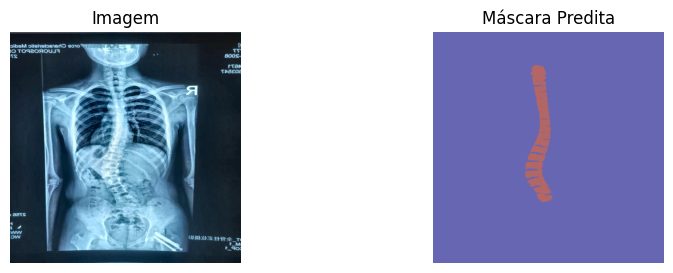

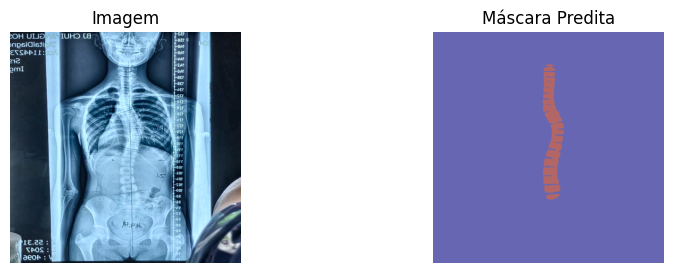

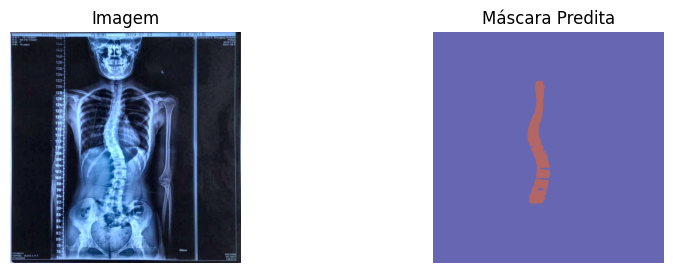

Métricas:
IoU: 0.8523
Dice: 0.9145
Precision: 0.8846
Recall: 0.9500
F1-Score: 0.9145
Pixel Accuracy: 0.9876


In [18]:
def segmentation_metrics(preds, targets, num_classes=2):
    """
    Calcula várias métricas de segmentação.

    Args:
        preds (torch.Tensor): As máscaras de predição do modelo.
        targets (torch.Tensor): As máscaras de verdade do dataset.
        num_classes (int): O número de classes (incluindo o fundo).

    Returns:
        dict: Um dicionário contendo as métricas calculadas.
    """
    # Garante que os tensores estejam na CPU e sejam arrays NumPy
    preds = preds.cpu().numpy().astype(np.uint8)
    targets = targets.cpu().numpy().astype(np.uint8)

    iou_list = []
    dice_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    # Itera sobre cada classe para calcular as métricas
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)

        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        pred_sum = pred_cls.sum()
        target_sum = target_cls.sum()

        # Evita divisão por zero
        precision = intersection / (pred_sum + 1e-6)
        recall = intersection / (target_sum + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        dice = (2. * intersection) / (pred_sum + target_sum + 1e-6)
        iou = intersection / (union + 1e-6)

        iou_list.append(iou)
        dice_list.append(dice)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Acurácia de pixel geral
    pixel_acc = (preds == targets).sum() / np.prod(targets.shape)

    return {
        'IoU': np.mean(iou_list),
        'Dice': np.mean(dice_list),
        'Precision': np.mean(precision_list),
        'Recall': np.mean(recall_list),
        'F1-Score': np.mean(f1_list),
        'Pixel Accuracy': pixel_acc
    }

def show_predictions(model, loader, n=3):
    """
    Exibe as predições do modelo e calcula as métricas de segmentação.
    """
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(n):
        img = imgs[i].cpu()
        mask = preds[i].cpu().numpy()

        plt.figure(figsize=(10,3))

        plt.subplot(1,2,1)
        plt.title("Imagem")
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title("Máscara Predita")
        plt.imshow(mask, cmap='jet', alpha=0.6)
        plt.axis('off')

        plt.show()

    # Agora a função segmentation_metrics existe e pode ser chamada
    metrics = segmentation_metrics(preds, masks)
    print("Métricas:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

# --- Chamada da Função ---
# Certifique-se de que 'model' e 'test_loader' estão definidos e carregados
print("\nVisualizando previsões...")
show_predictions(model, test_loader)

In [ ]:
import torch
import numpy as np

def segmentation_metrics(preds, targets, num_classes=2):
    preds = preds.cpu().numpy().astype(np.uint8)
    targets = targets.cpu().numpy().astype(np.uint8)

    iou_list = []
    dice_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)

        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        pred_sum = pred_cls.sum()
        target_sum = target_cls.sum()

        precision = intersection / (pred_sum + 1e-6)
        recall = intersection / (target_sum + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        dice = (2. * intersection) / (pred_sum + target_sum + 1e-6)
        iou = intersection / (union + 1e-6)

        iou_list.append(iou)
        dice_list.append(dice)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    pixel_acc = (preds == targets).sum() / np.prod(targets.shape)

    return {
        'IoU': np.mean(iou_list),
        'Dice': np.mean(dice_list),
        'Precision': np.mean(precision_list),
        'Recall': np.mean(recall_list),
        'F1-Score': np.mean(f1_list),
        'Pixel Accuracy': pixel_acc
    }

In [19]:
# Salvar
torch.save(model.state_dict(), "deeplabv3plus_escoliose_clahe.pth")

In [ ]:
# Carregar
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights=None,  # <- não carrega pesos do ImageNet, pois vai sobrescrever
    in_channels=3,
    classes=2
).to(device)

model.load_state_dict(torch.load("deeplabv3plus_escoliose.pth"))
model.eval()  # Coloca o modelo em modo de avaliação


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia